This morning, I saw the following post in my Twitter feed:

<blockquote class="twitter-tweet"><p lang="und" dir="ltr"><a href="https://t.co/dF16zlDcQZ">pic.twitter.com/dF16zlDcQZ</a></p>&mdash; Étienne Jacob (@etiennejcb) <a href="https://twitter.com/etiennejcb/status/1324780234978267137?ref_src=twsrc%5Etfw">November 6, 2020</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

This reminded me that I unsuccessfully tried to model potential flows before. So let's try again and maybe we will come close to what Étienne Jacob has made this morning.

We'll start with a little theory about potential flows, then we will try to solve the classic cylinder flow problem for which we have an analytical solution and finally we'll try to solve a more complex problem like the one Étienne posted.

# Theory about potential flows 

In some cases (see [Wikipedia](https://en.wikipedia.org/wiki/Potential_flow)), fluids can be modelled using a scalar potential function instead of a (more complicated) velocity field, which are related through

$$
\left \{
\begin{aligned}
\vec{v} & = \vec{grad}\varphi \\
\Delta \varphi & =  0
\end{aligned}
\right .
$$

In 2D, the Laplace equation for the potential is written as follows:

$$
\frac{\partial^2 \varphi}{\partial x^2} + \frac{\partial^2 \varphi}{\partial y^2} = 0
$$

I want to solve this problem on a square grid which features an airfoil-like region. We can do this by defining boundary conditions on the outer boundary $\Gamma_o$ ("the flow is undisturbed there") and the inner boundary $\Gamma_i$ ("the flow doesn't penetrate the airfoil there"). This is written:

$$
\left \{
\begin{aligned}
\vec{v}(x) \cdot \vec{n}(x) =  \vec{grad}\varphi (x)\cdot \vec{n}(x) = \vec{v}_0 \cdot \vec{n}(x) && \forall x \in \Gamma_o   \\
\vec{v}(x) \cdot \vec{n}(x) =  \vec{grad}\varphi (x)\cdot \vec{n}(x) = 0 && \forall x \in \Gamma_i 
\end{aligned}
\right .
$$



Now the next step is to discretize these equations using (naive) finite differences.

The discretized Laplace equation becomes:

$$
\frac{\varphi_{i+1, j} - 2 \varphi_{i, j} + \varphi_{i-1, j}}{\Delta x^2} + \frac{\varphi_{i, j+1} - 2 \varphi_{i, j} + \varphi_{i, j-1}}{\Delta y^2} = 0  
$$

For $\vec{v}_0 = v_{0x} \vec{e}_x + v_{0y} \vec{e}_y$, the outer boundary conditions become:

$$
\left \{
\begin{aligned}
\frac{\varphi_{1, j} - \varphi_{0, j}}{\Delta x} = -v_{0x} && \text{(left edge)} \\ 
\frac{\varphi_{n, j} - \varphi_{n-1, j}}{\Delta x} = v_{0x} && \text{(right edge)} \\ 
\frac{\varphi_{i, n} - \varphi_{i, n-1}}{\Delta x} = 0 && \text{(top edge)} \\ 
\frac{\varphi_{i, 1} - \varphi_{i, 0}}{\Delta x} = 0 && \text{(top edge)} \\ 
\end{aligned}
\right .
$$

For a point on the inner boundary $\Gamma_i$, $\vec{v}(x) \cdot \vec{n}(x) = 0$ becomes 

$$
\frac{\partial \varphi}{\partial x} n_x + \frac{\partial \varphi}{\partial y} n_y = 0
$$

# Potential flow around a sphere 

With all that being said, we can now try to tackle the solution to the sphere flow, for which we have [an analytical solution](https://en.wikipedia.org/wiki/Potential_flow_around_a_circular_cylinder) that will allow us to check our results. 

The ingredients we need for our solution algorithm are the following:

- build up a grid of the discretized potential 
- for each interior point, define the discretized Laplace operator
- for each point on the outer boundary, set the "infinite velocity"
- for each point on the inner boundary, apply the non-slip operator
- solve the obtained linear system

I should note that we have to make a choice here about how we define the interior boundary. Instead of using a discretized 2D curve, I think it is a good idea to use a continuous function to define this boundary, since it will allow us to easily compute the normal vector field needed to write the interior boundary condition.

Let's start by making some tools for the interior boundary curve and its normals on a discretized grid.

## Discretizing the interior boundary

In [1]:
import numpy as np

def make_grid(Lx=4, Ly=5, nx=50, ny=51):
    """Make a rectangular grid, with coordinates centered on (0, 0)."""
    x = np.linspace(0, Lx, num=nx) - Lx/2
    y = np.linspace(0, Ly, num=ny) - Ly/2
    X, Y = np.meshgrid(x, y)
    return X, Y

grid = make_grid(nx=25, ny=26)

Let's plot the grid to make sure it looks the way we think it should:

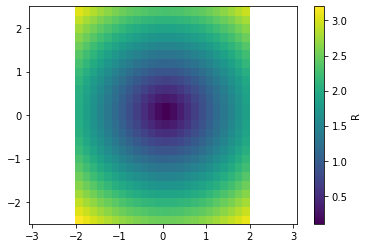

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

R = np.sqrt(grid[0]**2 + grid[1]**2)

fig, ax = plt.subplots()
m = ax.pcolormesh(grid[0], grid[1], R)
plt.colorbar(m, ax=ax, label='R')
ax.axis('equal');

The next step is to define the parametric circle curve.

In [3]:
# define a parametric circle
t = np.linspace(0, 2 * np.pi, num=35, endpoint=False)
x, y = np.cos(t), np.sin(t)
nx, ny = x / np.sqrt(x**2 + y**2), y / np.sqrt(x**2 + y**2)

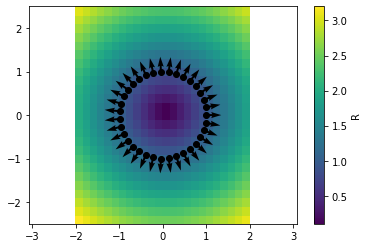

In [4]:
fig, ax = plt.subplots()
m = ax.pcolormesh(grid[0], grid[1], R)
plt.colorbar(m, ax=ax, label='R')
ax.plot(x, y, 'ok')
ax.quiver(x, y, nx, ny)
ax.axis('equal');

Now, a tricky thing to do is to find the discrete boundary on the grid we have defined. We need a way to loop on these points since we will need to apply the difference equations to these points. When we will have defined these points, it will be trivial to compute the normal vectors for them.

The strategy to do this will be:

- discretize the continuous curve to discrete points (x, y)
- use the discrete points to find their closest grid coordinates (r, c) (while not adding duplicate points)
- use a scikit-image function to find the grid coordinates between them `skimage.draw.line(r0, c0, r1, c1)`

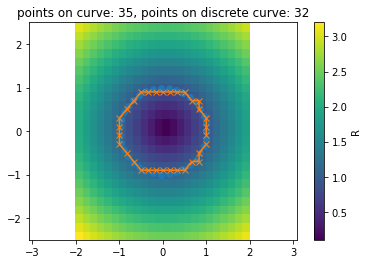

In [5]:
from skimage import draw

def transform_grid_coords_to_xy(grid_coords, grid):
    """Transform rc coords to xy coords from the grid."""
    X, Y = grid
    x_disc = np.array([X[rc[0], rc[1]] for rc in grid_coords])
    y_disc = np.array([Y[rc[0], rc[1]] for rc in grid_coords])
    return x_disc, y_disc

def rasterize_points_to_grid_coords(x, y, grid):
    """Rasterizes a discrete set of (x, y) points to a grid. Returns (r, c) coordinates."""
    X, Y = grid
    X_flat, Y_flat = X.flatten(), Y.flatten()

    r = np.arange(X.shape[0])
    c = np.arange(X.shape[1])
    C, R = np.meshgrid(c, r)
    R_flat, C_flat = R.flatten(), C.flatten()

    coords = np.c_[X_flat, Y_flat]
    coords_rc = np.c_[R_flat, C_flat]
    
    # first part: discretize each point from x and y while avoiding duplicates
    rcs = []
    discrete_coords = []
    already_seen_points = set()
    for xx, yy in zip(x, y):
        dist = ((coords - np.array([xx, yy]).reshape(1, -1))**2).sum(axis=1)
        argmin = dist.argmin()
        if argmin not in already_seen_points:            
            rc = coords_rc[argmin]
            rcs.append(rc)
            discrete_coords.append(coords[argmin])
            already_seen_points.add(argmin)

    discrete_coords = np.array(discrete_coords)
    x_disc, y_disc = transform_grid_coords_to_xy(rcs, grid)
    
    # sanity check
    assert np.allclose(np.c_[x_disc, y_disc], discrete_coords)

    # second part: use the Bresenham algorithm to discretize each segment
    N = len(rcs)
    grid_coords = []
    for start, stop in zip(range(N), range(1, N+1)):
        if stop >= N:
            stop = stop % N
        r0, c0 = rcs[start]
        r1, c1 = rcs[stop]
        rr, cc = draw.line(r0, c0, r1, c1)
        grid_coords.extend([r,c] for r, c in zip(rr[:-1], cc[:-1]))
        
    return np.array(grid_coords)

grid_coords = rasterize_points_to_grid_coords(x, y, grid)
x_disc, y_disc = transform_grid_coords_to_xy(grid_coords, grid)

fig, ax = plt.subplots()
m = ax.pcolormesh(grid[0], grid[1], np.sqrt(grid[0]**2 + grid[1]**2))
plt.colorbar(m, ax=ax, label='R')
ax.plot(x, y, 'o')
ax.plot(x_disc, y_disc, '-x')
ax.set_title(f'points on curve: {x.size}, points on discrete curve: {x_disc.size}')
ax.axis('equal');

Let's make an animation using a couple of discretization values to see if the algorithm works as expected.

In [6]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots()
m = ax.pcolormesh(grid[0], grid[1], np.sqrt(grid[0]**2 + grid[1]**2))
plt.colorbar(m, ax=ax, label='R')
l1, = ax.plot([], [], 'o')
l2, = ax.plot([], [], '-x')
ax.axis('equal')
    
def update(n):
    t = np.linspace(0, 2 * np.pi, num=n, endpoint=False)
    x, y = np.cos(t), np.sin(t)
    rcs = rasterize_points_to_grid_coords(x, y, grid)
    x_disc, y_disc = transform_grid_coords_to_xy(rcs, grid)
    l1.set_data(x, y)
    l2.set_data(x_disc, y_disc)
    ax.set_title(f'points on curve: {x.size}, points on discrete curve: {x_disc.size}')


anim = FuncAnimation(fig, update, frames=range(2, 50, 3))
#anim.save('anim2.mp4')
plt.close()
HTML(anim.to_jshtml())

## The normal vectors on the interior boundary 

Since we have now establised a clear link between the parametrized curve and the grid, we can move on to the computation of normal vectors at each grid point. Unfortunately, this involves copying a part of the previously discretization algorithm.

In [7]:
def rasterize_vectors_to_grid(x, y, nx, ny, grid):
    """Rasterizes a discrete set of (x, y) points and vectors (nx, ny) to a grid. 
    Returns (nx_disc, ny_disc) vector field."""

    X, Y = grid
    X_flat, Y_flat = X.flatten(), Y.flatten()

    r = np.arange(X.shape[0])
    c = np.arange(X.shape[1])
    C, R = np.meshgrid(c, r)
    R_flat, C_flat = R.flatten(), C.flatten()

    coords = np.c_[X_flat, Y_flat]
    coords_rc = np.c_[R_flat, C_flat]
    
    # first part: discretize each point from x and y while avoiding duplicates
    rcs = []
    discrete_coords = []
    discrete_vectors = []
    already_seen_points = set()
    for xx, yy, nxx, nyy in zip(x, y, nx, ny):
        dist = ((coords - np.array([xx, yy]).reshape(1, -1))**2).sum(axis=1)
        argmin = dist.argmin()
        if argmin not in already_seen_points:            
            rc = coords_rc[argmin]
            rcs.append(rc)
            discrete_coords.append(coords[argmin])
            discrete_vectors.append([nxx, nyy])
            already_seen_points.add(argmin)

    discrete_coords = np.array(discrete_coords)
    x_disc, y_disc = transform_grid_coords_to_xy(rcs, grid)
    
    # sanity check
    assert np.allclose(np.c_[x_disc, y_disc], discrete_coords)

    # second part: use the Bresenham algorithm to discretize each segment
    N = len(rcs)
    grid_coords = []
    rasterized_vector_field = []
    for start, stop in zip(range(N), range(1, N+1)):
        if stop >= N:
            stop = stop % N
        r0, c0 = rcs[start]
        r1, c1 = rcs[stop]
        nx0, ny0 = discrete_vectors[start]
        nx1, ny1 = discrete_vectors[stop]
        
        rr, cc = draw.line(r0, c0, r1, c1)
        N_interp = len(rr) 
        for i in range(N_interp - 1):
            alpha = i/N_interp
            grid_coords.append([rr[i], cc[i]])
            rasterized_vector_field.append([(1 - alpha) * nx0 + alpha * nx1,
                                            (1 - alpha) * ny0 + alpha * ny1])
    return np.array(rasterized_vector_field)

Let's test this and do a simple test.

In [8]:
grid_coords = rasterize_points_to_grid_coords(x, y, grid)
x_disc, y_disc = transform_grid_coords_to_xy(grid_coords, grid)
rasterized_vector_field = rasterize_vectors_to_grid(x, y, nx, ny, grid)

assert rasterized_vector_field.shape[0] == x_disc.size

And now let's plot the discretized vector fields.

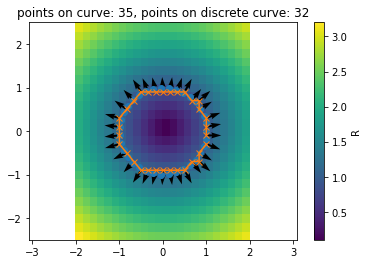

In [9]:
fig, ax = plt.subplots()
m = ax.pcolormesh(grid[0], grid[1], np.sqrt(grid[0]**2 + grid[1]**2))
plt.colorbar(m, ax=ax, label='R')
ax.plot(x, y, 'o')
ax.plot(x_disc, y_disc, '-x')
ax.quiver(x_disc, y_disc, rasterized_vector_field[:, 0], rasterized_vector_field[:, 1])
ax.set_title(f'points on curve: {x.size}, points on discrete curve: {x_disc.size}')
ax.axis('equal');

Let's do some further checks through some plots.

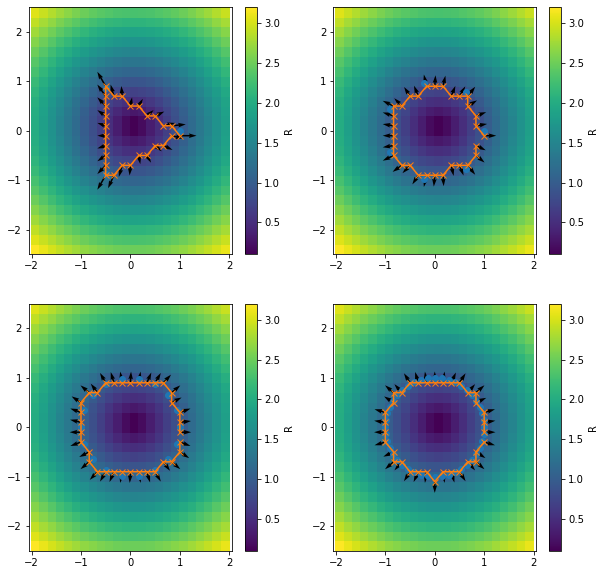

In [10]:
def make_data_and_plot(n, ax):
    t = np.linspace(0, 2 * np.pi, num=n, endpoint=False)
    x, y = np.cos(t), np.sin(t)
    nx, ny = x / np.sqrt(x**2 + y**2), y / np.sqrt(x**2 + y**2)
    grid_coords = rasterize_points_to_grid_coords(x, y, grid)
    x_disc, y_disc = transform_grid_coords_to_xy(grid_coords, grid)
    rasterized_vector_field = rasterize_vectors_to_grid(x, y, nx, ny, grid)
    # plotting
    ax.plot(x, y, 'o')
    ax.plot(x_disc, y_disc, '-x')
    ax.quiver(x_disc, y_disc, rasterized_vector_field[:, 0], rasterized_vector_field[:, 1])

n_points = [3, 7, 18, 44]

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))

for ax, n in zip(axes.ravel(), n_points):
    m = ax.pcolormesh(grid[0], grid[1], np.sqrt(grid[0]**2 + grid[1]**2))
    make_data_and_plot(n, ax)
    plt.colorbar(m, ax=ax, label='R')
    ax.axis('equal')

Ok, this looks like what I expect. Let's now move on to the finite difference approximation.

## Setting up the finite difference problem geometry

Let's first distinguish the three regions we need to set up the problem:

- the outer boundary
- the inner boundary 
- the rest of the region

In [11]:
from skimage.draw import polygon


def make_tags(grid, x, y):
    """Create a grid with tags defining each cell's type."""
    X, Y = grid
    r = np.arange(X.shape[0])
    c = np.arange(X.shape[1])
    C, R = np.meshgrid(c, r)

    xmin, xmax = X.min(), X.max()
    ymin, ymax = Y.min(), Y.max()
    EPS = 1e-5

    grid_coords = rasterize_points_to_grid_coords(x, y, grid)
    grid_coords_set = set((r,c) for (r,c) in grid_coords)
    mask = polygon(np.array(grid_coords)[:, 0], np.array(grid_coords)[:, 1], X.shape)
    mask_set = set((r, c) for r, c in zip(*mask))

    tags = np.zeros_like(R, dtype=np.int) * np.nan

    for r, c in zip(R.flatten(), C.flatten()):
        # left boundary
        if abs(X[r, c] - xmin) < EPS:
            tags[r, c] = 1
        # right boundary
        elif abs(X[r, c] - xmax) < EPS:
            tags[r, c] = 2
        # bottom boundary
        elif abs(Y[r, c] - ymin) < EPS:
            tags[r, c] = 3
        # top boundary
        elif abs(Y[r, c] - ymax) < EPS:
            tags[r, c] = 4
        # interior
        elif (r, c) in mask_set:
            # boundary
            if (r, c) in  grid_coords_set:
                tags[r, c] = 5
            # volume inside
            else:
                tags[r, c] = 6
        else:
            tags[r, c] = 7

    for r,c in grid_coords:
        tags[r, c] = 5
    return tags

tags = make_tags(grid, x, y)

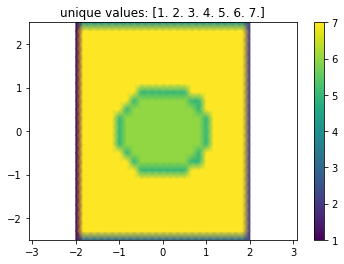

In [12]:
fig, ax = plt.subplots()
m = ax.pcolormesh(grid[0], grid[1], tags, shading='Gouraud')
plt.colorbar(m, ax=ax)
ax.axis('equal')
ax.set_title(f"unique values: {np.unique(tags[~np.isnan(tags)])}");

## Doing the equations: constant flow case

As a first step, we will model the potential value at each grid point and do as if there was no interior region.

In [13]:
X, Y = grid
r = np.arange(X.shape[0])
c = np.arange(X.shape[1])
C, R = np.meshgrid(c, r)

has_unknown = np.ones_like(tags, dtype=bool)
rcs = np.c_[R[has_unknown].flatten(), C[has_unknown].flatten()]

# Let's create some mappings to simplify the mapping.

rc2id = {}
id2rc = {}

for ind, (r, c) in enumerate(rcs):
    rc2id[(r, c)] = ind
    id2rc[ind] = (r, c)

# coef matrix
A = np.zeros((rcs.shape[0], rcs.shape[0]))
# rhs vector
B = np.zeros((rcs.shape[0],))
# v0
v0 = np.array([1., 0])
# grid params
dx = 1
dy = 1

for (r, c) in rc2id:
    this_point = rc2id[(r, c)]
    # left edge
    if tags[r, c] == 1:
        id_right = rc2id[(r, c+1)]
        id_left = rc2id[(r, c)]
        A[this_point, id_left] += 1/dx
        A[this_point, id_right] += -1/dx
        B[this_point] = -v0[0]
    # right edge
    elif tags[r, c] == 2:
        id_right = rc2id[(r, c)]
        id_left = rc2id[(r, c-1)]
        A[this_point, id_right] += 1/dx
        A[this_point, id_left] += -1/dx
        B[this_point] = v0[0]
    # top edge
    elif tags[r, c] == 4:
        id_top = rc2id[(r, c)]
        id_bottom = rc2id[(r-1, c)]
        A[this_point, id_top] += 1/dy
        A[this_point, id_bottom] += -1/dy
        B[this_point] = 0
    # bottom edge
    elif tags[r, c] == 3:
        id_top = rc2id[(r, c)]
        id_bottom = rc2id[(r+1, c)]
        A[this_point, id_top] += 1/dy
        A[this_point, id_bottom] += -1/dy
        B[this_point] = 0
    # interior boundary, interior volume and exterior volume
    else:
        id_bottom = rc2id[(r-1, c)]
        id_top = rc2id[(r+1, c)]
        id_right = rc2id[(r, c+1)]
        id_left = rc2id[(r, c-1)]
        id_center = rc2id[(r, c)]
        A[this_point, id_top] += -1/dy
        A[this_point, id_bottom] += -1/dy
        A[this_point, id_right] += -1/dx
        A[this_point, id_left] += -1/dx
        A[this_point, id_center] += (2/dx + 2/dy)

phi_sol = np.linalg.solve(A, B)

Let's now do the inverse mapping of phi to a square matrix and visualize it.

(-2.2, 2.2, -2.75, 2.75)

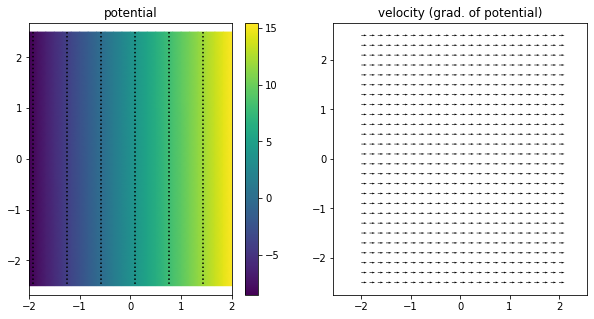

In [14]:
phi_mapped = np.zeros_like(tags) * np.nan
for _id, rc in id2rc.items():
    phi_mapped[rc[0], rc[1]] = phi_sol[_id]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
m = ax1.pcolormesh(grid[0], grid[1], phi_mapped, shading='Gouraud')
ax1.contour(grid[0], grid[1], phi_mapped, linestyles='dotted', colors="black")
plt.colorbar(m, ax=ax1)
ax1.axis('equal')
ax1.set_title("potential");

u, v = np.gradient(phi_mapped)
ax2.quiver(X, Y, v, u)
ax2.set_title("velocity (grad. of potential)");
ax2.axis('equal')

## With an obstacle 

Let's now add the last step: use the discretized boundary of the immersed object and add that back into the equations. 
Contrary to the previous computation, we will only compute a solution for nodes that are not tagged "6" (which defines the nodes within theinner boundary). We can find all coordinates of the grid points with a boolean operation.

In [15]:
def assemble_and_solve(grid, x, y, nx, ny, tags):
    """Assembles and solves the potential flow from a curve (x, y, nx, ny) and on the given grid."""
    grid_coords = rasterize_points_to_grid_coords(x, y, grid)
    rasterized_vector_field = rasterize_vectors_to_grid(x, y, nx, ny, grid)

    assert grid_coords.shape[0] == rasterized_vector_field.shape[0]

    rc2normal = {}
    for rc, n in zip(grid_coords, rasterized_vector_field):
        rc2normal[(rc[0], rc[1])] = n

    X, Y = grid
    r = np.arange(X.shape[0])
    c = np.arange(X.shape[1])
    C, R = np.meshgrid(c, r)

    has_unknown = (tags != 6)
    rcs = np.c_[R[has_unknown].flatten(), C[has_unknown].flatten()]

    # Let's create some mappings to simplify the loops.

    rc2id = {}
    id2rc = {}

    for ind, (r, c) in enumerate(rcs):
        rc2id[(r, c)] = ind
        id2rc[ind] = (r, c)

    # coef matrix
    A = np.zeros((rcs.shape[0], rcs.shape[0]))
    # rhs vector
    B = np.zeros((rcs.shape[0],))
    # v0
    v0 = np.array([1., 0])
    # grid params
    dx = X[0, 1] - X[0, 0]
    dy = Y[1, 0] - Y[0, 0]

    for (r, c) in rc2id:
        this_point = rc2id[(r, c)]
        # left edge
        if tags[r, c] == 1:
            id_right = rc2id[(r, c+1)]
            id_left = rc2id[(r, c)]
            A[this_point, id_left] += 1/dx
            A[this_point, id_right] += -1/dx
            B[this_point] = -v0[0]
        # right edge
        elif tags[r, c] == 2:
            id_right = rc2id[(r, c)]
            id_left = rc2id[(r, c-1)]
            A[this_point, id_right] += 1/dx
            A[this_point, id_left] += -1/dx
            B[this_point] = v0[0]
        # top edge
        elif tags[r, c] == 4:
            id_top = rc2id[(r, c)]
            id_bottom = rc2id[(r-1, c)]
            A[this_point, id_top] += 1/dy
            A[this_point, id_bottom] += -1/dy
            B[this_point] = 0
        # bottom edge
        elif tags[r, c] == 3:
            id_top = rc2id[(r, c)]
            id_bottom = rc2id[(r+1, c)]
            A[this_point, id_top] += 1/dy
            A[this_point, id_bottom] += -1/dy
            B[this_point] = 0
        # point on the interior boundary
        elif tags[r, c] == 5:
            nxx, nyy = rc2normal[(r, c)]
            id_center = rc2id[(r, c)]
            # vertical gradient
            if (r-1, c) in rc2id:
                id_bottom = rc2id[(r-1, c)]
                A[this_point, id_center] += 1/(dy) * nyy
                A[this_point, id_bottom] += -1/(dy) * nyy
            else:
                id_top = rc2id[(r+1, c)]
                A[this_point, id_center] += -1/(dy) * nyy
                A[this_point, id_top] += 1/(dy) * nyy

            # horizontal gradient
            if (r, c+1) in rc2id:
                id_right = rc2id[(r, c+1)]
                A[this_point, id_right] += 1/(dx) * nxx
                A[this_point, id_center] += -1/(dx) * nxx
            else:
                id_left = rc2id[(r, c-1)]
                A[this_point, id_center] += 1/(dx) * nxx
                A[this_point, id_left] += -1/(dx) * nxx

        # inside the volume
        elif tags[r, c] == 6:
            id_center = rc2id[(r, c)]
            A[this_point, id_center] = 1
            B[this_point] = 0
        else:
            id_bottom = rc2id[(r-1, c)]
            id_top = rc2id[(r+1, c)]
            id_right = rc2id[(r, c+1)]
            id_left = rc2id[(r, c-1)]
            id_center = rc2id[(r, c)]
            A[this_point, id_top] += -1/dy
            A[this_point, id_bottom] += -1/dy
            A[this_point, id_right] += -1/dx
            A[this_point, id_left] += -1/dx
            A[this_point, id_center] += (2/dx + 2/dy)

    phi_sol = np.linalg.solve(A, B)
    phi_mapped = np.zeros_like(tags) * np.nan
    for _id, rc in id2rc.items():
        phi_mapped[rc[0], rc[1]] = phi_sol[_id]
    return phi_mapped

phi_mapped = assemble_and_solve(grid, x, y, nx, ny, tags)

(-2.2, 2.2, -2.75, 2.75)

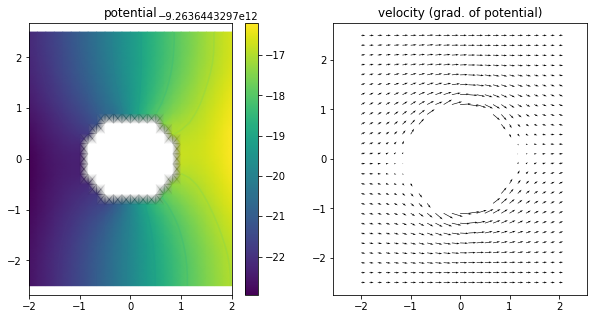

In [16]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
m = ax1.pcolormesh(grid[0], grid[1], phi_mapped, shading='Gouraud')
ax1.contour(grid[0], grid[1], phi_mapped)
plt.colorbar(m, ax=ax1)
ax1.axis('equal')
ax1.set_title("potential");

u, v = np.gradient(phi_mapped)
ax2.quiver(X, Y, v, u)
ax2.set_title("velocity (grad. of potential)");
ax2.axis('equal')

(-2.0, 2.0, -2.7600697927262074, 2.759110974697001)

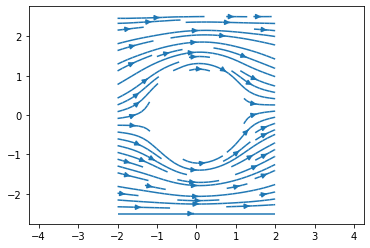

In [17]:
fig, ax = plt.subplots()
ax.streamplot(X, Y, v, u)
ax.axis('equal')

This doesn't look too bad! Let's see if we can compare this to the analytical solution and let's also study the effect of discretization.

# Studying the effect of discretization

There's actually two discretizations to study: 

- the grid itself
- the geometric curve of the interior boundary


## Discretizing the grid 

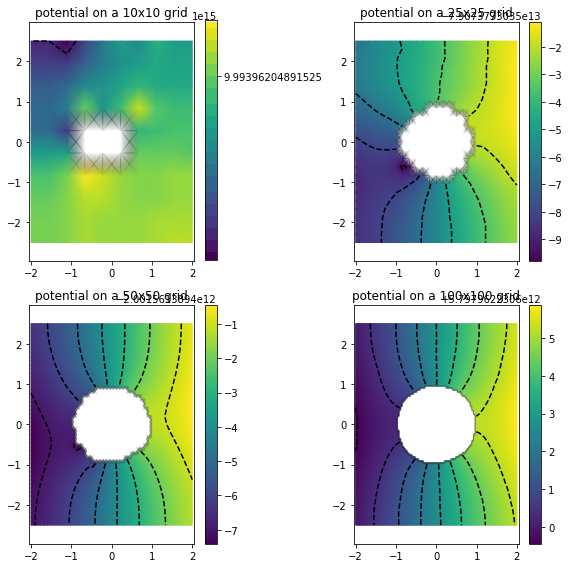

In [18]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 8))

# discrete curve
t = np.linspace(0, 2 * np.pi, num=35, endpoint=False)
x, y = np.cos(t), np.sin(t)
nx, ny = x / np.sqrt(x**2 + y**2), y / np.sqrt(x**2 + y**2)

for n, ax in zip([10, 25, 50, 100], axes.ravel()):

    grid = make_grid(nx=n, ny=n)
    tags = make_tags(grid, x, y)
    phi_mapped = assemble_and_solve(grid, x, y, nx, ny, tags)
    m = ax.pcolormesh(grid[0], grid[1], phi_mapped, shading='Gouraud')
    ax.contour(grid[0], grid[1], phi_mapped, linestyles='dashed', colors='black')
    plt.colorbar(m, ax=ax)
    ax.axis('equal')
    ax.set_title(f"potential on a {n}x{n} grid")

plt.tight_layout();

The finer the grid, the smoother the result.

## Discretizing the geometric curve 

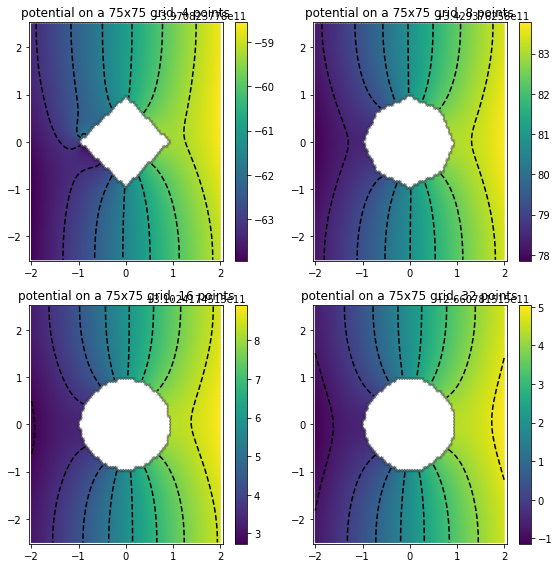

In [19]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 8))


for n, ax in zip([4, 8, 16, 32], axes.ravel()):
    # discrete curve
    t = np.linspace(0, 2 * np.pi, num=n, endpoint=False)
    x, y = np.cos(t), np.sin(t)
    nx, ny = x / np.sqrt(x**2 + y**2), y / np.sqrt(x**2 + y**2)


    grid = make_grid(nx=75, ny=75)
    tags = make_tags(grid, x, y)
    phi_mapped = assemble_and_solve(grid, x, y, nx, ny, tags)
    m = ax.pcolormesh(grid[0], grid[1], phi_mapped, shading='Gouraud')
    ax.contour(grid[0], grid[1], phi_mapped, linestyles='dashed', colors='black')
    plt.colorbar(m, ax=ax)
    ax.axis('equal')
    ax.set_title(f"potential on a 75x75 grid, {n} points")

plt.tight_layout();

## Comparing with the analytical solution 

We're now at the point where we can compare the potential we have computated with the analytical sphere flow solution.

$$\phi (r,\theta )=Ur\left(1+{\frac {R^{2}}{r^{2}}}\right)\cos \theta \,.$$

$$V_{r}={\frac {\partial \phi }{\partial r}}=U\left(1-{\frac {R^{2}}{r^{2}}}\right)\cos \theta $$

$$ V_{\theta }={\frac {1}{r}}{\frac {\partial \phi }{\partial \theta }}=-U\left(1+{\frac {R^{2}}{r^{2}}}\right)\sin \theta \,.$$

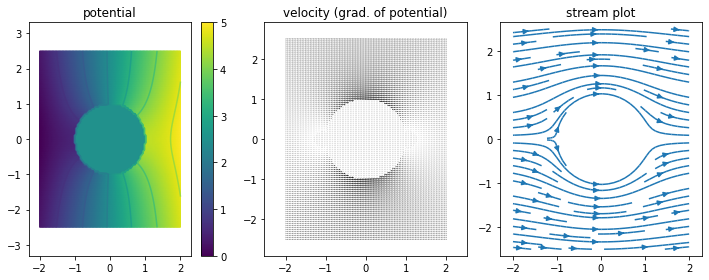

In [20]:
def compute_analytical_solution(grid, U, R):
    """Applies analytical solution of cylinder flow to every point in the grid."""
    X, Y = grid
    r = np.sqrt(X**2 + Y**2)
    theta = np.arctan2(Y, X)
    phi = U * r * (1 + R**2/r**2) * np.cos(theta) * (r > R)
    phi -= phi.min() # normalizing by minimum value
    v_r = U * (1 - R**2 / r**2) * np.cos(theta) * (r > R)
    v_theta = -U * (1 + R**2 / r**2) * np.sin(theta) * (r > R)
    v_x = np.cos(theta) * v_r - np.sin(theta) * v_theta
    v_y = np.sin(theta) * v_r + np.cos(theta) * v_theta

    return phi, v_x, v_y

def compute_gradient(grid, phi):
    """Numerically computes velocity as gradient of phi on grid."""
    X, Y = grid
    dx = X[0, 1] - X[0, 0]
    dy = Y[1, 0] - Y[0, 0]
    v, u = np.gradient(phi, dx, dy)
    return u, v

def make_plot(phi_mapped, grid, uv=None):
    """Plots a solution to the potential flow on the grid."""
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(10, 4))
    m = ax1.pcolormesh(grid[0], grid[1], phi_mapped, shading='Gouraud')
    ax1.contour(grid[0], grid[1], phi_mapped)
    plt.colorbar(m, ax=ax1)
    ax1.axis('equal')
    ax1.set_title("potential")
    
    if uv is not None:
        u, v = uv
    else:
        u, v = compute_gradient(grid, phi_mapped)

    ax2.quiver(grid[0], grid[1], u, v)
    ax2.set_title("velocity (grad. of potential)");
    ax2.axis('equal')
    ax3.streamplot(grid[0], grid[1], u, v)
    ax3.set_title('stream plot')
    ax3.axis('equal')
    plt.tight_layout()

grid = make_grid(nx=100, ny=101)
phi_exact, v_x_exact, v_y_exact = compute_analytical_solution(grid, 1, 1)

make_plot(phi_exact, grid, uv=(v_x_exact, v_y_exact))

Let's compare that with our numerical solution.

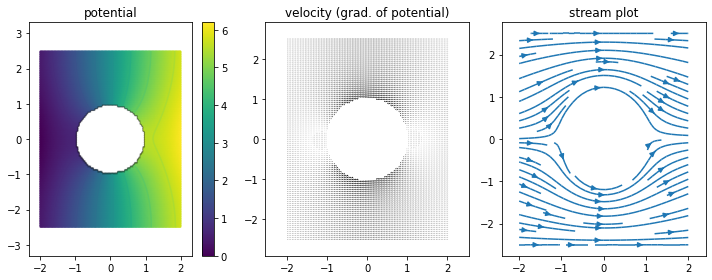

In [21]:
t = np.linspace(0, 2 * np.pi, num=127, endpoint=False)
x, y = np.cos(t), np.sin(t)
nx, ny = x / np.sqrt(x**2 + y**2), y / np.sqrt(x**2 + y**2)
tags = make_tags(grid, x, y)
phi_mapped = assemble_and_solve(grid, x, y, nx, ny, tags)
phi_mapped -= np.nanmin(phi_mapped)

make_plot(phi_mapped, grid)

# Solving a heart curve 

Let's now turn to solving something like I hoped in the introduction of this post: the heart curve.

There are a number of different ones to choose from, [according to MathWorld](https://mathworld.wolfram.com/HeartCurve.html).

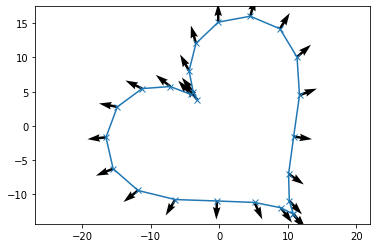

In [22]:
def rotate_curve(x, y, rotation_angle):
    """Rotates a curve by a given angle."""
    rotation_angle = np.deg2rad(rotation_angle)
    x, y = np.cos(rotation_angle) * x - np.sin(rotation_angle) * y, np.cos(rotation_angle) * y + np.sin(rotation_angle) * x
    return x, y

t = np.linspace(0, 2 * np.pi, num=25, endpoint=False)
x = 16*np.sin(t)**3
y = 13*np.cos(t) - 5 *np.cos(2*t) -2 *np.cos(3*t) - np.cos(4*t)
x, y = rotate_curve(x, y, 40)
nx, ny = x / np.sqrt(x**2 + y**2), y / np.sqrt(x**2 + y**2)

fig, ax = plt.subplots()
ax.plot(x, y, '-x')
ax.quiver(x, y, nx, ny)
ax.axis('equal');

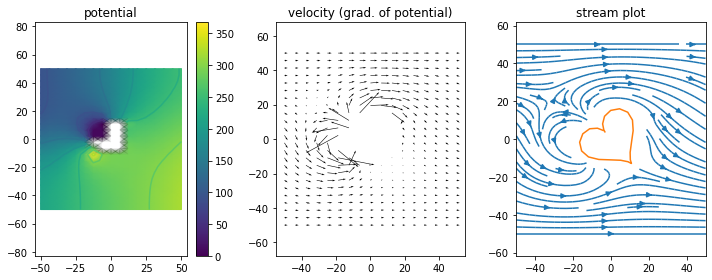

In [23]:
grid = make_grid(Lx=100, Ly=100, nx=17, ny=24)
tags = make_tags(grid, x, y)
phi_mapped = assemble_and_solve(grid, x, y, nx, ny, tags)
phi_mapped -= np.nanmin(phi_mapped)

make_plot(phi_mapped, grid)
plt.plot(x, y)

# Solving a butterfly curve 

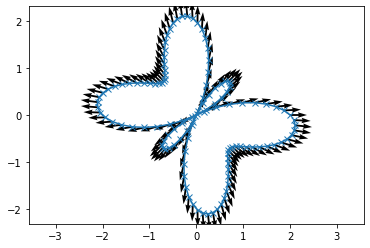

In [24]:
t = np.linspace(0, 2 * np.pi, num=121, endpoint=False)
r_polar = 1 - np.sin(2*t) + np.cos(4*t)
x, y = r_polar * np.cos(t), r_polar * np.sin(t)
x, y = rotate_curve(x, y, 0)
nx, ny = x / np.sqrt(x**2 + y**2), y / np.sqrt(x**2 + y**2)

fig, ax = plt.subplots()
ax.plot(x, y, '-x')
ax.quiver(x, y, nx, ny)
ax.axis('equal');

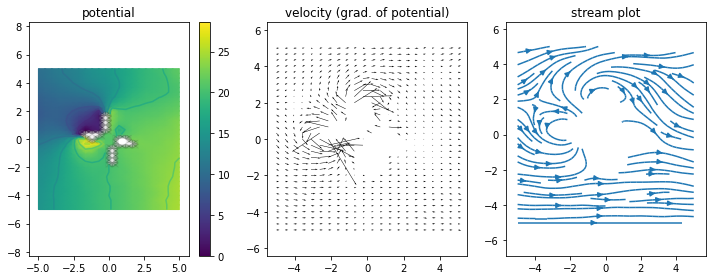

In [25]:
grid = make_grid(Lx=10, Ly=10, nx=22, ny=31)
tags = make_tags(grid, x, y)
phi_mapped = assemble_and_solve(grid, x, y, nx, ny, tags)
phi_mapped -= np.nanmin(phi_mapped)

make_plot(phi_mapped, grid)

To get this result, I actually had to tweak the grid quite a lot, since the finite difference scheme breaks down when the angles of the curve are too sharp. I won't go into the details here but if you play with the code yourself, you'll quickly find that it's difficult to make a fine-grid simulation with the above heart and butterfly curves.

# Animating the butterfly 

Since this post started with an animation, I'm going to try to finish it with an animation. Using the computed velocity grid, we can move a population of random particles across the grid.

In [26]:
from scipy.interpolate import interp2d

u, v = compute_gradient(grid, phi_mapped)

u[np.isnan(u)] = 0
v[np.isnan(v)] = 0

interp_u = interp2d(grid[0], grid[1], u, kind='cubic')
interp_v = interp2d(grid[0], grid[1], v, kind='cubic')

fig, ax = plt.subplots()
n_particles = 100
positions = np.c_[-4 * np.ones((n_particles,)), 2 * np.random.rand(n_particles)]
l, = ax.plot(positions[:, 0], positions[:, 1], 'o')
ax.set_xlim((grid[0].min(), grid[0].max()))
ax.set_ylim((grid[1].min(), grid[1].max()))
ax.plot(x, y)
ax.quiver(grid[0], grid[1], u, v)
ax.set_title("velocity (grad. of potential)");
ax.axis('equal')

def move(t):
    global positions
    step = .005
    for _ in range(20):
        uu = np.diag(interp_u(positions[:, 0], positions[:, 1]))
        vv = np.diag(interp_v(positions[:, 0], positions[:, 1]))
        positions[:, 0] += step * uu
        positions[:, 1] += -step * vv
    l.set_data(positions[:, 0], positions[:, 1])
    

anim = FuncAnimation(fig, move, frames=np.arange(50))
plt.close()
HTML(anim.to_jshtml())

*This post was entirely written using the Jupyter Notebook. Its content is BSD-licensed. You can see a static view or download this notebook with the help of nbviewer at [20201107_PotentialFlowRedux.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20201107_PotentialFlowRedux.ipynb).*